In [8]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import time
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


# Pytorch device specific configuration
# Pytorch Gpu Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

# # Font update global for all plots
# plt.rcParams.update({"font.size": 18})

In [9]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=";")
data = data[data["total sulfur dioxide"] < 200]  # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop("quality")
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# create a new column for binarized (boolean) quality
data["boolQuality"] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
data.loc[data["quality"] > 5, "boolQuality"] = 1

In [11]:
# convert from pandas dataframe to tensor
dataT = torch.tensor(data[cols2zscore].values).float()
labels = torch.tensor(data["boolQuality"].values).float()
# transform to matrix
labels = labels.reshape(labels.shape[0], 1)
labels.shape

torch.Size([1597, 1])

In [13]:
# use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(
    dataT, labels, test_size=0.1
)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# finally, translate into dataloader objects
batchsize = 32
train_loader = DataLoader(
    train_data,
    batch_size=batchsize,
    shuffle=True,
    drop_last=True,
    generator=torch.Generator(device),
)
test_loader = DataLoader(
    test_data,
    batch_size=test_data.tensors[0].shape[0],
    generator=torch.Generator(device),
)

In [14]:
# Class to create a model
class ANNwine(nn.Module):
    def __init__(self):
        super().__init__()
        #### Layers
        # Input
        self.input = nn.Linear(11, 16)

        # Hidden
        self.fc1 = nn.Linear(16, 32)
        self.fc2 = nn.Linear(32, 32)

        # Output
        self.output = nn.Linear(32, 1)

        # Forward Function

    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        return self.output(x)

In [15]:
# test the model
net = ANNwine()
net(torch.randn(10, 11)).shape

torch.Size([10, 1])

In [ ]:
# a function that trains the model


def trainTheModel(winenet, numepochs):

    # loss function and optimizer
    lossfun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(winenet.parameters(), lr=0.01)

    # initialize losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    # loop over epochs
    for epochi in range(numepochs):

        # turn on training mode
        winenet.train()

        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = winenet(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute training accuracy for this batch
            batchAcc.append(100 * torch.mean(((yHat > 0) == y).float()).item())
        # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append(np.mean(batchAcc))

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        winenet.eval()
        X, y = next(iter(test_loader))  # extract X,y from test dataloader
        with torch.no_grad():  # deactivates autograd
            yHat = winenet(X)
        testAcc.append(100 * torch.mean(((yHat > 0) == y).float()).item())

    # function output
    return trainAcc, testAcc, losses

In [27]:
#### Experiment: initialize weights and test model for xavier initialization
# Create and train the model
winenet_xavier = ANNwine()

for p in winenet_xavier.named_parameters():
    if "weight" in p[0]:
        nn.init.xavier_uniform_(p[1].data)

# Train the model
trainAcc_xavier, testAcc_xavier, losses_xavier = trainTheModel(winenet_xavier, 300)

In [28]:
#### Experiment: initialize weights and test model for xavier initialization
# Create and train the model
winenet_kaiming = ANNwine()

for p in winenet_kaiming.named_parameters():
    if "weight" in p[0]:
        nn.init.kaiming_uniform_(p[1].data)

# Train the model
trainAcc_kaiming, testAcc_kaiming, losses_kaiming = trainTheModel(winenet_kaiming, 300)

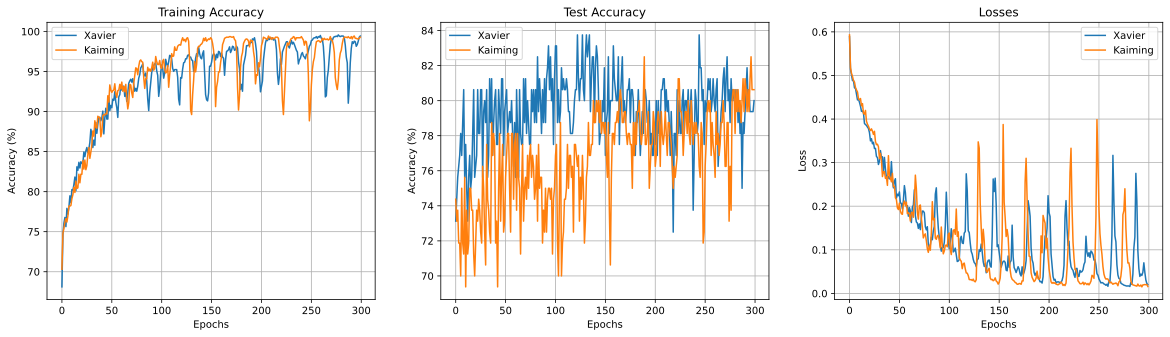

In [29]:
# Plot the results
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Training Accuracy
ax[0].plot(trainAcc_xavier, label="Xavier")
ax[0].plot(trainAcc_kaiming, label="Kaiming")
ax[0].set_title("Training Accuracy")
ax[0].set_ylabel("Accuracy (%)")

# Test Accuracy
ax[1].plot(testAcc_xavier, label="Xavier")
ax[1].plot(testAcc_kaiming, label="Kaiming")
ax[1].set_title("Test Accuracy")
ax[1].set_ylabel("Accuracy (%)")

# Losses
ax[2].plot(losses_xavier.cpu().detach(), label="Xavier")
ax[2].plot(losses_kaiming.cpu().detach(), label="Kaiming")
ax[2].set_title("Losses")
ax[2].set_ylabel("Loss")

for i in range(3):
    ax[i].legend()
    ax[i].grid("on")
    ax[i].set_xlabel("Epochs")

plt.show()